Need to have torch installed (so I switched from my tensorflow to torch conda env)

In [1]:
# Check if we have data.zip:
import os
if not os.path.exists('data.zip'):
    # Download the data:
    !wget https://download.pytorch.org/tutorial/data.zip
if not os.path.exists('data'):
    # Unzip the data:
    !unzip data.zip

In [2]:
import sys
sys.path.append("../../Code/Lecture6-NamesRNN/")

from rnn_utils import *

['data/names/Spanish.txt', 'data/names/French.txt', 'data/names/Dutch.txt', 'data/names/Scottish.txt', 'data/names/Czech.txt', 'data/names/Arabic.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Vietnamese.txt', 'data/names/Japanese.txt', 'data/names/Polish.txt', 'data/names/Chinese.txt', 'data/names/Russian.txt', 'data/names/English.txt', 'data/names/Italian.txt', 'data/names/Irish.txt', 'data/names/Korean.txt', 'data/names/Portuguese.txt']
Slusarski


In [3]:
import torch.nn as nn

class NonLinearRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, 
                 nonlinearity=nn.Tanh()):
        super(NonLinearRNN, self).__init__()

        self.hidden_size = hidden_size
        # Combine input and hidden states (concatenation)
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # Send hidden states to output
        self.h2o = nn.Linear(hidden_size, output_size)
        # Output will be in logits
        self.softmax = nn.LogSoftmax(dim=1)
        # Non-linearity
        self.nonlinearity = nonlinearity

    def forward(self, input, hidden):
        # First combine the input and hidden state on the first axis
        combined = torch.cat((input, hidden), 1)
        # Then send it to the hidden layer (linear layer)
        hidden = self.i2h(combined)
        # Insert non-linearity between the linear layers
        hidden = self.nonlinearity(hidden)

        # Then send it to the output layer (linear layer) as logit
        output = self.h2o(hidden)
        output = self.softmax(output)

        # We'll want both the output (logit for each class) 
        # and the hidden state for the next step
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = NonLinearRNN(n_letters, n_hidden, n_categories)

In [11]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-3.6601, -3.2886, -2.9824, -3.9358, -3.5646, -3.3989, -3.8534, -3.2791,
         -2.6934, -1.8567, -3.4817, -2.9473, -3.4134, -3.0670, -2.9816, -2.5553,
         -1.5578, -3.8809]], grad_fn=<LogSoftmaxBackward0>)


In [12]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)
print(categoryFromOutput(output))

tensor([[-3.6601, -3.2886, -2.9824, -3.9358, -3.5646, -3.3989, -3.8534, -3.2791,
         -2.6934, -1.8567, -3.4817, -2.9473, -3.4134, -3.0670, -2.9816, -2.5553,
         -1.5578, -3.8809]], grad_fn=<LogSoftmaxBackward0>)
('Korean', 16)


In [6]:
losses, val_losses, test_loss = train_loop(rnn, 0.001, 5e5, device='cpu')

5000 1% (0m 3s) 2.8845 Sook / Russian ✗ (Korean)
10000 2% (0m 8s) 2.8091 Ko / Italian ✗ (Korean)
15000 3% (0m 12s) 2.8541 Hanania / Czech ✗ (Arabic)
20000 4% (0m 16s) 2.4724 Nardi / Italian ✓
25000 5% (0m 20s) 2.5869 Copland / Portuguese ✗ (English)
30000 6% (0m 24s) 3.9528 Haimi / Japanese ✗ (Russian)
35000 7% (0m 28s) 2.5939 Rios / Arabic ✗ (Portuguese)
40000 8% (0m 33s) 2.1937 Pinho / Italian ✗ (Portuguese)
45000 9% (0m 37s) 1.9680 Quyen / Korean ✗ (Vietnamese)
50000 10% (0m 41s) 0.8383 Yan / Chinese ✓
55000 11% (0m 45s) 1.2795 Sitko / Polish ✓
60000 12% (0m 49s) 0.4681 Takudo / Japanese ✓
65000 13% (0m 54s) 0.1045 Chrysanthopoulos / Greek ✓
70000 14% (0m 58s) 1.0486 Vuu / Vietnamese ✓
75000 15% (1m 2s) 1.1456 Ankeren / Dutch ✓
80000 16% (1m 6s) 5.2304 Lis / Korean ✗ (Polish)
85000 17% (1m 11s) 1.7930 Simoes / Greek ✗ (Portuguese)
90000 18% (1m 15s) 1.7281 Cabral / French ✗ (Portuguese)
95000 19% (1m 19s) 1.4893 Silveira / Spanish ✗ (Portuguese)
100000 20% (1m 23s) 1.1012 Kosmatka /

(0.0, 3.0)

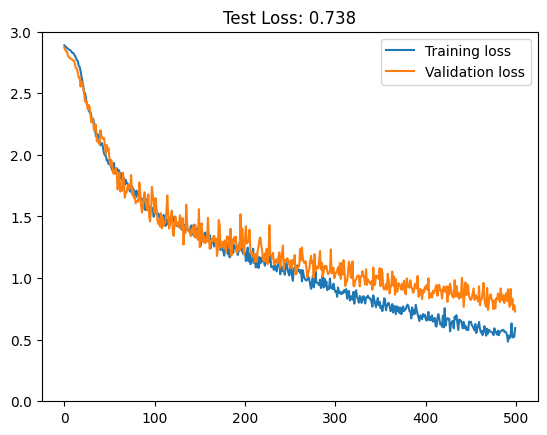

In [10]:
plt.figure()
plt.plot(losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title('Test Loss: {:.3f}'.format(test_loss))
plt.ylim(0,3)

/tmp/ipykernel_2567770/3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_2567770/3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


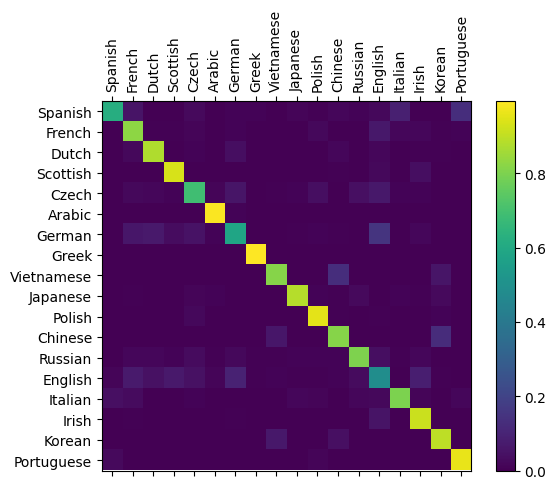

In [8]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [9]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate( lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Kulkarni') # Indian
predict('Haehn')
predict('Adamczyk') # Polish
predict('Piemontese') # Italian
predict('Makarenko') # Ukrainian
predict('Olshanii') # Russian


> Kulkarni
(-0.50) Polish
(-1.77) Greek
(-2.58) Italian

> Haehn
(-0.58) German
(-1.94) Dutch
(-2.36) English

> Adamczyk
(-0.08) Polish
(-3.11) Czech
(-3.74) Russian

> Piemontese
(-0.67) English
(-1.38) French
(-2.59) German

> Makarenko
(-0.01) Russian
(-4.71) Japanese
(-7.03) Czech

> Olshanii
(-0.45) Russian
(-1.63) Italian
(-2.08) Czech
